# Variational Autoencoder  
## Exercise 7

In [1]:
import torch
import MNIST_dataloader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch import nn, optim
from typing import Dict, Optional, Tuple, List
import sys

In [2]:
# %% set torches random seed
torch.random.manual_seed(0)

model_loc = os.path.join(os.path.abspath("."),"model")
fig_path = os.path.join(os.path.abspath("."),"figure")

In [3]:
# %% preperations
# define parameters

data_loc = os.path.join(os.path.abspath("."),"MNIST") #change the data location to something that works for you
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)


In [4]:
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

In [86]:
# Define Autoencoder
# Encoder

class Encoder(nn.Module):
    def __init__(self,in_channel=3):
        super(Encoder, self).__init__()
        # create layers here
        self.encoder = nn.Sequential(
        nn.Conv2d(in_channel,16,kernel_size=3,padding=1), #(N,3,32,32)->(N,16,32,32)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), #(N,16,32,32)->(N,16,16,16)
        nn.Conv2d(16,16,3,padding=1), #(N,16,16,16)->(N,16,16,16)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), # (N,16,16,16)->(N,16,8,8)
        nn.Conv2d(16,16,3,padding=1), #(N,16,8,8)->(N,16,8,8)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), # (N,16,4,4)
        nn.Conv2d(16,16,3,padding=1), #(N,16,4,4)->(N,16,4,4)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), # (N,16,2,2)
        nn.Flatten()
        )
        self.fc_mu = nn.Linear(16*2*2,2)
        self.fc_log_var = nn.Linear(16*2*2,2)

        self.n = torch.distributions.Normal(0,1)
        self.kl = 0
        
    def forward(self, x):
        # use the created layers here
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        sigma = torch.exp(log_var/2)
        z = mu + sigma*self.n.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma)-1/2).sum()
        return mu, sigma, z
    
# Decoder
class Decoder(nn.Module):
    def __init__(self,out_channel=3):
        super(Decoder, self).__init__()
        # create layers here
        self.fc1 = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(1,16,3,padding=1), #(N,1,4,4)->(N,16,4,4)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Upsample(scale_factor=2), #(N,16,4,4)->(N,16,8,8)
        nn.ConvTranspose2d(16,16,3,padding=1), # (N,16,8,8)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Upsample(scale_factor=2), #(N,16,8,8)->(N,16,16,16)
        nn.ConvTranspose2d(16,16,3,padding=1), # (N,16,16,16)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Upsample(scale_factor=2), #(N,16,32,32)->(N,16,32,32)
        nn.ConvTranspose2d(16,out_channel,3,padding=1), # (N,16,32,32)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, h):
        # use the created layers here
        fc1 = self.fc1(h)
        fc1 = fc1.reshape(-1,1,4,4)
        r = self.sigmoid(self.decoder(fc1))
        return fc1,r
    
# Autoencoder
class VAE(nn.Module):
    def __init__(self,channel=3):
        super(VAE, self).__init__()
        self.encoder = Encoder(channel)
        self.decoder = Decoder(channel)
    
    def forward(self, x):
        mu,sigma,z = self.encoder(x)
        fc1,r = self.decoder(z)
        return mu, sigma,fc1,r

In [87]:
# Sanity check
sanity_check = torch.ones((64,1,32,32))
encoder_check = Encoder(1)
mu,sigma,z = encoder_check.forward(sanity_check)
print(f"Encoder check:{mu.shape},{sigma.shape},{z.shape}")
decoder_check = Decoder(1)
fc1,r = decoder_check.forward(z)
print(f"Decoder check:{fc1.shape},{r.shape}")
VAE_check = VAE(1)
mu, log_std,fc1,r = VAE_check.forward(sanity_check)
print(f"VAE check:{r.shape}")
latent_check = torch.ones((64,2))
fc1,output_check = VAE_check.decoder(latent_check)
print(f"VAE.decoder check:{output_check.shape}")

Encoder check:torch.Size([64, 2]),torch.Size([64, 2]),torch.Size([64, 2])
Decoder check:torch.Size([64, 1, 4, 4]),torch.Size([64, 1, 32, 32])
VAE check:torch.Size([64, 1, 32, 32])
VAE.decoder check:torch.Size([64, 1, 32, 32])


In [88]:
model_VAE = VAE(1).to(device)
learning_rate = 3e-4
no_epochs = 30
optimizer_VAE = optim.Adam(model_VAE.parameters(),lr = learning_rate)
loss_iter = []
loss_epoch = []
loss_iter_test = []
loss_epoch_test = []
torch.random.manual_seed(0)


in VAE, $p_2=\mathcal{N}_2(0,1)$  
$\mathrm{KL}(p_1||p_2)$ = $-\frac{1}{2}\times [ 2log\sigma_1+1-\sigma^2_1-\mu^2_1]$

In [89]:
import torch.nn.functional as F

for epoch in range(no_epochs):
    print(f"Training on {device}. Epoch {epoch+1}:")
    # go over all minibatches
    # sys.stdout.flush()
    total_loss=0
    model_VAE.train()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(train_loader):
        # fill in how to train your network using only the clean images
        optimizer_VAE.zero_grad()
        inputs = x_clean.to(device=device)
        mu,sigma,fc1,outputs= model_VAE(inputs)
        # recst_loss = F.mse_loss(outputs,inputs)
        # kl_div = -0.5*torch.sum(log_var+1-mu.pow(2)-log_var.exp()) / batch_size
        loss = F.mse_loss(outputs,inputs,reduction='sum') + model_VAE.encoder.kl
        # loss = torch.sum((outputs-inputs)**2)+kl_div
        loss.backward()
        optimizer_VAE.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    print(f'Epoch[{epoch+1}/{no_epochs}],Loss(Train):{total_loss/len(train_loader)}')
    # sys.stdout.flush()
    total_loss = 0
    model_VAE.eval()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(test_loader):
        inputs = x_clean.to(device=device)
        mu,sigma,fc1,outputs= model_VAE(inputs)
        # recst_loss = F.mse_loss(outputs,inputs)
        # kl_div = -0.5*torch.sum(log_var+1-mu.pow(2)-log_var.exp()) / batch_size
        # loss_test = recst_loss + kl_div
        loss_test = ((outputs-inputs)**2).sum() + model_VAE.encoder.kl
        loss_iter_test.append(loss_test.data)
        total_loss += loss_test.data
    loss_epoch_test.append(total_loss/len(test_loader))
    print(f'Epoch[{epoch+1}/{no_epochs}],Loss(Test):{total_loss/len(test_loader)}')


torch.save(model_VAE,os.path.join(model_loc,'exercise_VAE.ptg'))

Training on cpu. Epoch 1:
Epoch[1/30],Loss(Train):61353.86328125
Epoch[1/30],Loss(Test):57613.87890625
Training on cpu. Epoch 2:
Epoch[2/30],Loss(Train):57533.6328125
Epoch[2/30],Loss(Test):57048.61328125
Training on cpu. Epoch 3:
Epoch[3/30],Loss(Train):57213.2578125
Epoch[3/30],Loss(Test):56864.921875
Training on cpu. Epoch 4:
Epoch[4/30],Loss(Train):57089.24609375
Epoch[4/30],Loss(Test):56777.0625
Training on cpu. Epoch 5:
Epoch[5/30],Loss(Train):57022.96875
Epoch[5/30],Loss(Test):56726.70703125
Training on cpu. Epoch 6:
Epoch[6/30],Loss(Train):56980.45703125
Epoch[6/30],Loss(Test):56696.6796875
Training on cpu. Epoch 7:
Epoch[7/30],Loss(Train):56946.55078125
Epoch[7/30],Loss(Test):56664.81640625
Training on cpu. Epoch 8:
Epoch[8/30],Loss(Train):56920.01953125
Epoch[8/30],Loss(Test):56630.1328125
Training on cpu. Epoch 9:
Epoch[9/30],Loss(Train):56896.75390625
Epoch[9/30],Loss(Test):56630.453125
Training on cpu. Epoch 10:
Epoch[10/30],Loss(Train):56878.1875
Epoch[10/30],Loss(Test):5

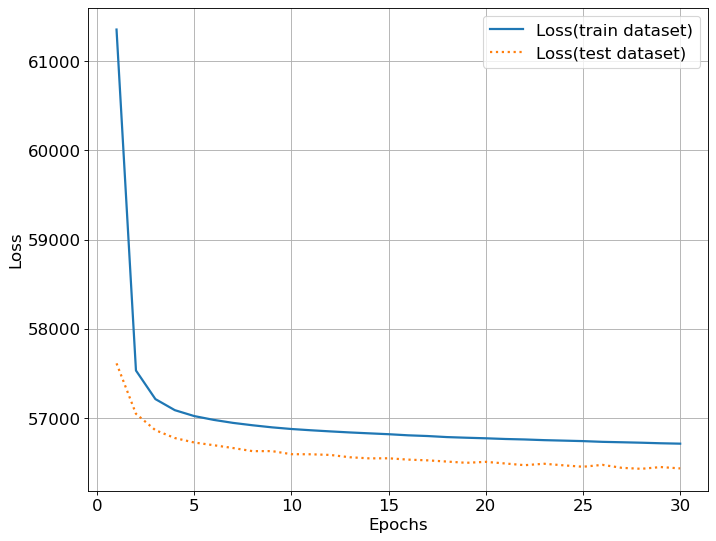

In [90]:
plt.figure(figsize=(10,8),dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
plt.plot(range(1,no_epochs+1),loss_epoch,label='Loss(train dataset)',linestyle='-',linewidth=2)
plt.plot(range(1,no_epochs+1),loss_epoch_test,label='Loss(test dataset)',linestyle=':',linewidth=2)
plt.legend(loc=1,prop={'size': 15})
plt.xlabel("Epochs",fontdict={'size':15})
plt.ylabel("Loss",fontdict={'size':15})

plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.savefig(os.path.join(fig_path,"Exercise_VAE_loss.png"),dpi=80,bbox_inches='tight')
plt.show()

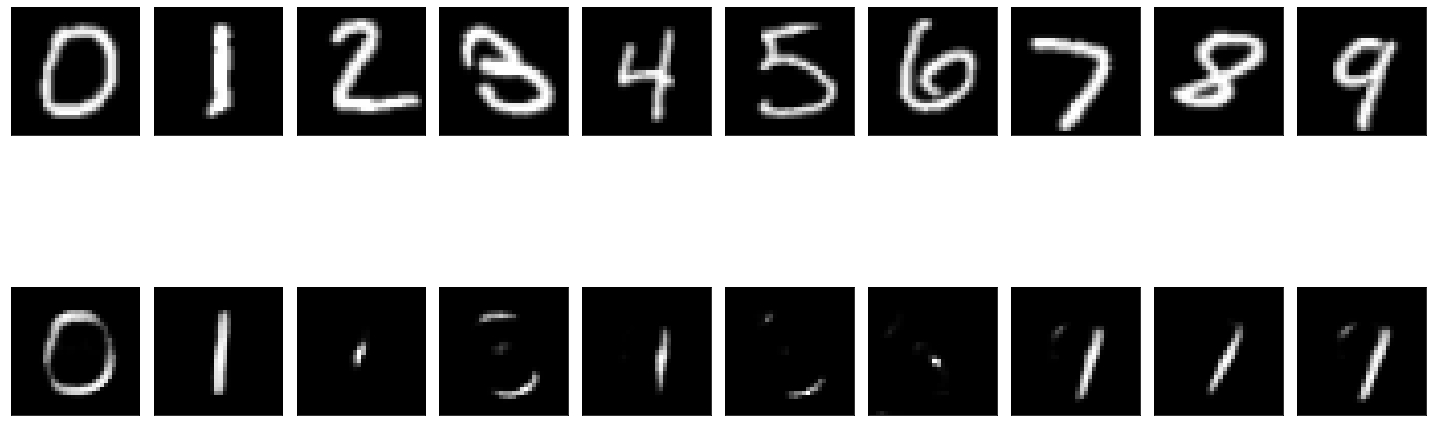

In [91]:
model_VAE = torch.load(os.path.join(model_loc,"exercise_VAE.ptg"))

examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
with torch.no_grad():
    mu,log_var,fc1,output_VAE = model_VAE(x_clean_example)

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,10,i+11)
    plt.imshow(output_VAE[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath("."),"figure")
plt.savefig(os.path.join(fig_path,"exercise_VAE_examples.png"),dpi=80,bbox_inches='tight')
plt.show()


In [92]:
model_VAE.eval()
with torch.no_grad():
    mu,log_var,fc1,outputs = model_VAE(x_clean_test)


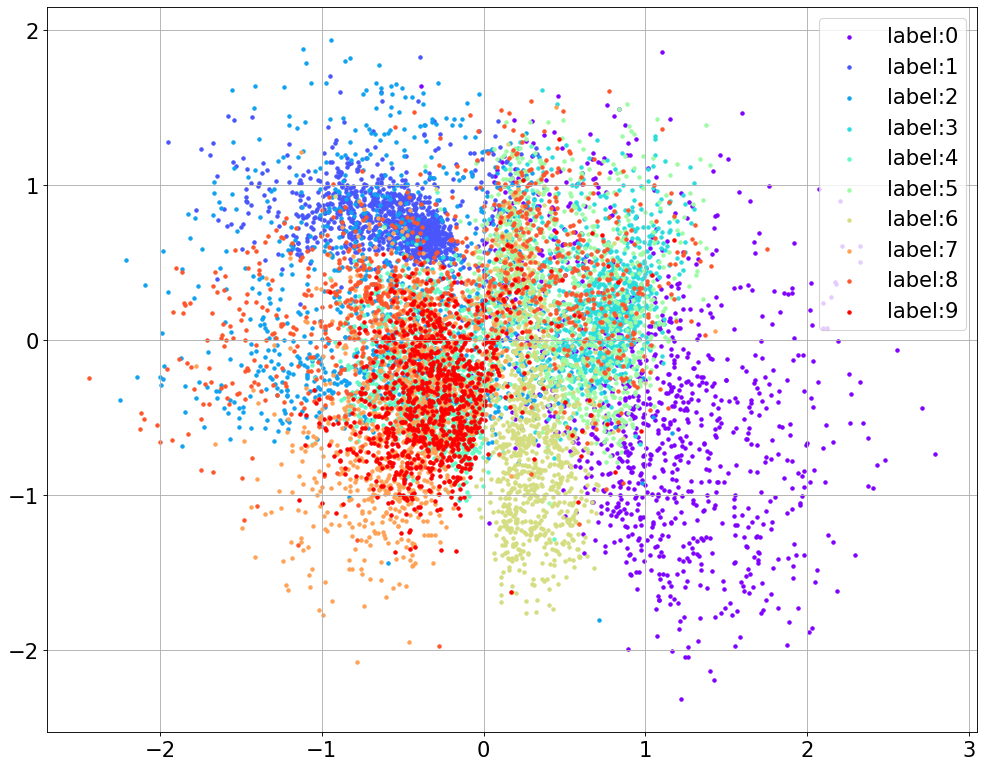

In [93]:
import matplotlib.cm as cm
import numpy as np

colors = cm.rainbow(np.linspace(0, 1,10))
plt.figure(figsize=(15,12),dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
    c = colors[i]
    latent_c = mu[torch.where(labels_test==i)]
    # if i == 3 or i==6:
    plt.scatter(latent_c[:,0], latent_c[:,1], color=c,label=f"label:{i}",marker='.')

plt.xticks(size=19)
plt.yticks(size=19)
plt.legend(loc=1,prop={'size': 19})
plt.grid()
plt.savefig(os.path.join(fig_path,"Exercise_VAE_scatter.png"),dpi=80,bbox_inches='tight')
plt.show()

In [94]:
x = torch.arange(-2.5,0,2.5/15)
y = torch.arange(-1.5,0.5,2/15)
latent_VAE = torch.zeros((15*15,2),requires_grad=False)
for i in range(15):
    for j in range(15):
        latent_VAE[i*15+j,:] = torch.Tensor([x[i],y[j]])

with torch.no_grad():
    _,output_VAE = model_VAE.decoder(latent_VAE)

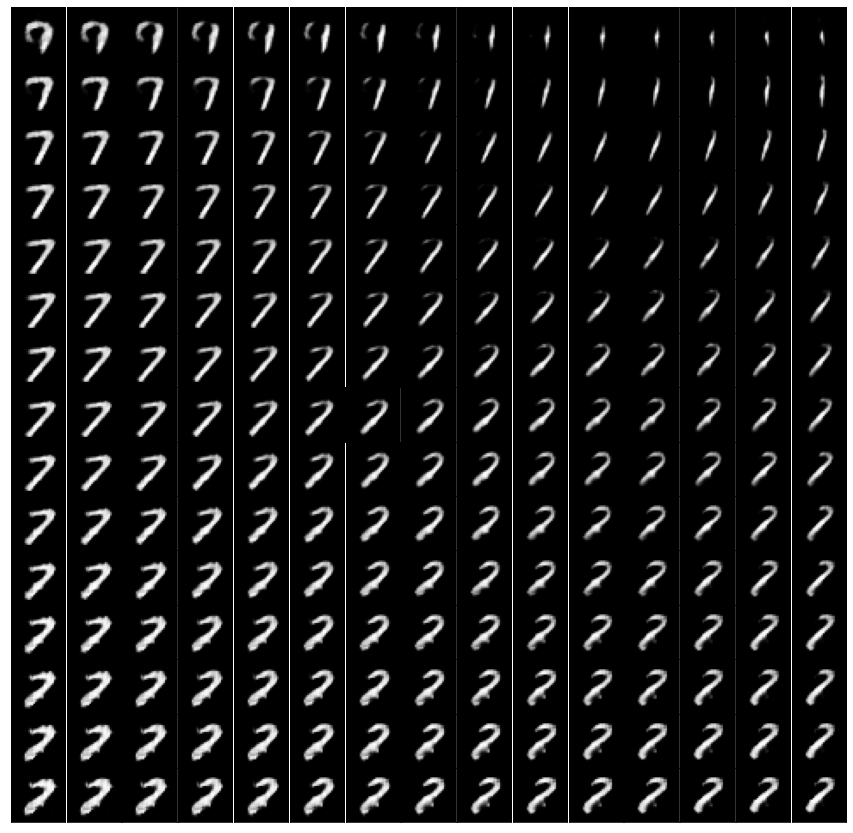

In [95]:
plt.figure(figsize=(15,15))
for i in range(15):
    for j in range(15):
        plt.subplot(15,15,i*15+j+1)
        plt.imshow(output_VAE[(14-i)*15+j,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.subplots_adjust(wspace=0,hspace=0)
fig_path = os.path.join(os.path.abspath("."),"figure")
plt.savefig(os.path.join(fig_path,"exercise5_VAE.png"),dpi=80,bbox_inches='tight')
plt.show()